Muhammad Azhar Firdaus<br>22.11.4695 IF04<br>P - Big Data Mining<br>UAS<br>
Link Dataset : (https://www.kaggle.com/datasets/ankushpanday1/heart-attack-in-youth-vs-adults-in-indonesia)

# **Import Library**

In [174]:
# Tahap 1: Import Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# **Load Dataset**

In [175]:
# Tahap 2: Load Dataset
file_path = "heart_attack_indonesia.csv"
data = pd.read_csv(file_path)
print("Data Head:\n", data.head())
print("\nInfo Dataset:")
data.info()

Data Head:
    ID      State  Age HeartAttack  Gender  Cholesterol SmokingHabits  \
0   1  Pekanbaru   32          No    Male          179        Smoker   
1   2   Makassar   15         Yes  Female          201    Non-smoker   
2   3   Surabaya   41          No  Female          167    Non-smoker   
3   4     Malang   31          No    Male          287        Smoker   
4   5       Bali   19          No    Male          239        Smoker   

  PhysicalActivity   BMI Hypertension  ... EducationLevel MaritalStatus  \
0             High  19.1          Yes  ...      Secondary        Single   
1             High  26.9           No  ...      Secondary       Married   
2         Moderate  29.6          Yes  ...        Primary        Single   
3         Moderate  19.4           No  ...         Higher        Single   
4             High  18.5           No  ...      Secondary       Married   

  FamilyHistoryHeartDisease IncomeLevel HealthcareAccess SleepHours  \
0                        No      

# **EDA**

In [176]:
data.dtypes

,0
ID,int64
State,object
Age,int64
HeartAttack,object
Gender,object
Cholesterol,int64
SmokingHabits,object
PhysicalActivity,object
BMI,float64
Hypertension,object


In [177]:
# Tahap 3: Exploratory Data Analysis (EDA)
# Distribusi fitur numerik dan kategori
data.describe().T
data.select_dtypes(include=['object']).nunique()

,0
State,15
HeartAttack,2
Gender,2
SmokingHabits,2
PhysicalActivity,3
Hypertension,2
Diabetes,2
AlcoholConsumption,2
DietType,2
OccupationType,2


In [178]:
# Gunakan kolom 'HeartAttack' sebagai target
data['HeartAttack'] = data['HeartAttack'].map({'Yes': 1, 'No': 0})

# Pisahkan fitur dan target
X = data.drop(columns=['HeartAttack'])
y = data['HeartAttack']

In [179]:
# Deteksi missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
ID                               0
State                            0
Age                              0
HeartAttack                      0
Gender                           0
Cholesterol                      0
SmokingHabits                    0
PhysicalActivity                 0
BMI                              0
Hypertension                     0
Diabetes                         0
AlcoholConsumption           56628
DietType                         0
OccupationType                   0
StressLevel                      0
EducationLevel                   0
MaritalStatus                    0
FamilyHistoryHeartDisease        0
IncomeLevel                      0
HealthcareAccess                 0
SleepHours                       0
UrbanOrRural                     0
AirQualityIndex                  0
PollutionLevel                   0
EmploymentStatus                 0
dtype: int64


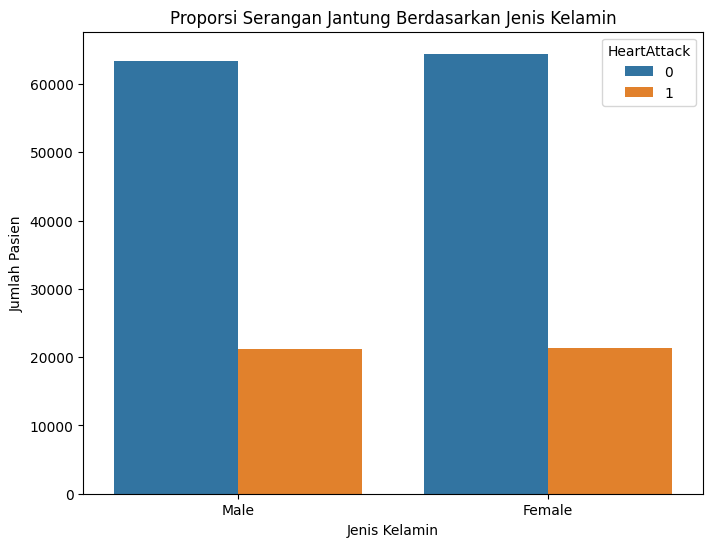

In [180]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Gender', hue='HeartAttack')
plt.title('Proporsi Serangan Jantung Berdasarkan Jenis Kelamin')
plt.xlabel('Jenis Kelamin')
plt.ylabel('Jumlah Pasien')
plt.show()

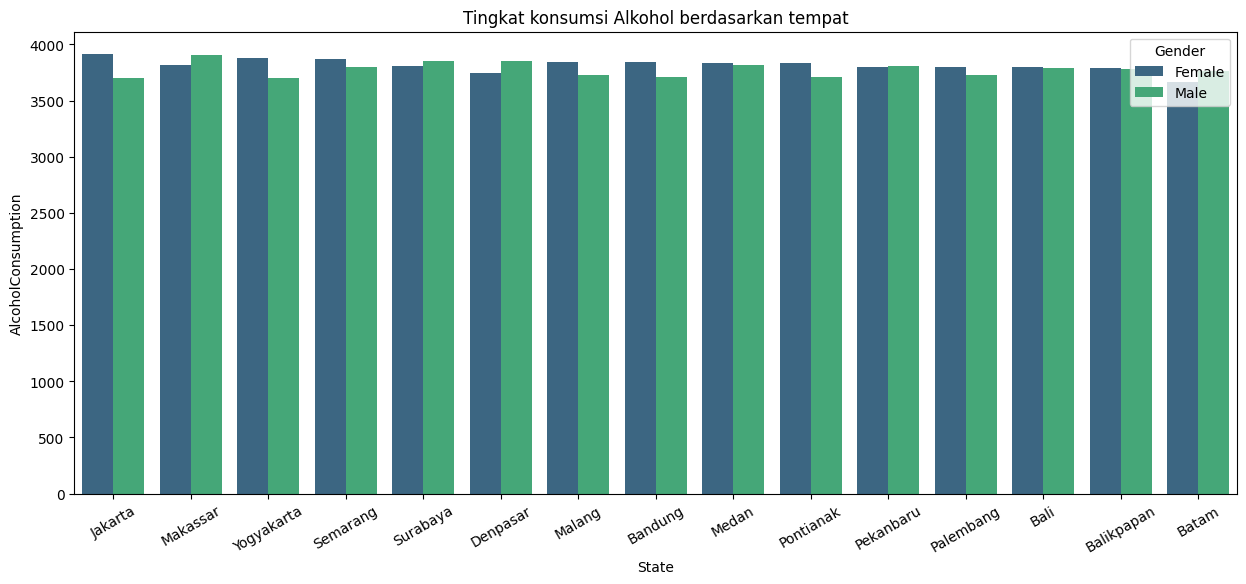

In [181]:
plt.figure(figsize=(15, 6))
g1=data.groupby(['State','Gender'])['AlcoholConsumption'].count().reset_index().sort_values(by='AlcoholConsumption',ascending=False)
sns.barplot(data=g1, x='State',y='AlcoholConsumption',hue='Gender',palette='viridis')#size='Gender',
plt.title("Tingkat konsumsi Alkohol berdasarkan tempat")
plt.xticks(rotation=30)
plt.show()

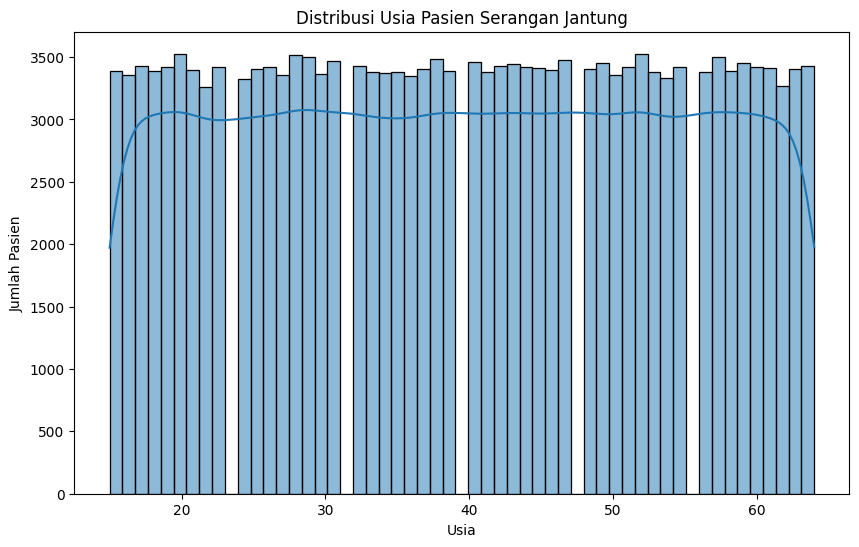

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data['Age'], kde=True)
plt.title('Distribusi Usia Pasien Serangan Jantung')
plt.xlabel('Usia')
plt.ylabel('Jumlah Pasien')
plt.show()

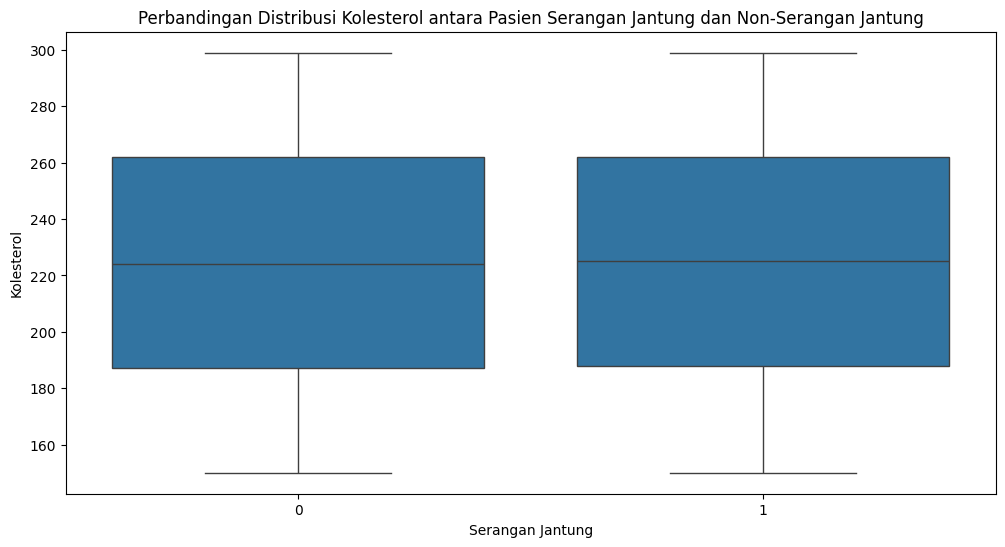

In [183]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='HeartAttack', y='Cholesterol')
plt.title('Perbandingan Distribusi Kolesterol antara Pasien Serangan Jantung dan Non-Serangan Jantung')
plt.xlabel('Serangan Jantung')
plt.ylabel('Kolesterol')
plt.show()

# **Preprocessing**

In [184]:
# Tahap 4: Preprocessing
# Memisahkan fitur dan target
X = data.drop(columns=['HeartAttack'])
y = data['HeartAttack']

In [185]:
# Tangani nilai hilang
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])


In [186]:
# Balancing dataset dengan SMOTE
smote = SMOTE(random_state=42)

# **Feature Selection**

In [187]:
# Tahap 5: Feature Selection
selector_num = SelectKBest(score_func=f_classif, k=5)
selector_cat = SelectKBest(score_func=chi2, k=5)

In [188]:
# Pipeline dengan preprocessing
preprocessing_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote)
])


# **Modeling**

In [189]:
# Tahap 6: Modeling
X_resampled, y_resampled = preprocessing_pipeline.fit_resample(X, y) # Changed to unpack the tuple

In [190]:
# Model Logistic Regression
logistic_model = Pipeline(steps=[
    ('feature_selection', selector_num),
    ('logistic', LogisticRegression(random_state=42))
])

logistic_model.fit(X_resampled, y_resampled) # Changed to use X_resampled and y_resampled
y_pred_logistic = logistic_model.predict(X_resampled) # Changed to use X_resampled
print("\nLogistic Regression Performance:")
print(classification_report(y_resampled, y_pred_logistic)) # Changed to use y_resampled


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.52      0.41      0.46    127826
           1       0.51      0.62      0.56    127826

    accuracy                           0.51    255652
   macro avg       0.52      0.51      0.51    255652
weighted avg       0.52      0.51      0.51    255652



In [191]:
# Apply preprocessing to X to create X_processed
X_processed = preprocessor.fit_transform(X) # Use preprocessor defined earlier


In [192]:
# Model Neural Network
nn_model = MLPClassifier(random_state=42, max_iter=500)
nn_model.fit(X_processed, y) # Now using the correctly preprocessed data
y_pred_nn = nn_model.predict(X_processed)
print("\nNeural Network Performance:")
print(classification_report(y, y_pred_nn))


Neural Network Performance:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86    127826
           1       0.59      0.02      0.03     42675

    accuracy                           0.75    170501
   macro avg       0.67      0.51      0.45    170501
weighted avg       0.71      0.75      0.65    170501



# **Evaluasi**

In [193]:
# Tahap 7: Evaluasi Model
roc_auc_logistic = roc_auc_score(y, logistic_model.predict_proba(X_processed)[:, 1])
roc_auc_nn = roc_auc_score(y, nn_model.predict_proba(X_processed)[:, 1])
print("\nROC-AUC Score Logistic Regression:", roc_auc_logistic)
print("ROC-AUC Score Neural Network:", roc_auc_nn)


ROC-AUC Score Logistic Regression: 0.5016215998661259
ROC-AUC Score Neural Network: 0.6417347952613272


# **Interpretasi Model**

In [194]:
# Tahap 8: Interpretasi Model
logistic_coefficients = logistic_model.named_steps['logistic'].coef_
print("\nLogistic Regression Coefficients:")
print(logistic_coefficients)


Logistic Regression Coefficients:
[[ 0.02105137 -0.0527191   0.07883331 -0.11050104 -0.06160753]]


# **Save Model**

In [195]:
# Simpan model dan dokumentasi
import joblib
joblib.dump(logistic_model, "logistic_model.pkl")
joblib.dump(nn_model, "nn_model.pkl")

['nn_model.pkl']

# **Menggunakan Model**

In [196]:
import joblib

logistic_model = joblib.load('logistic_model.pkl')
nn_model = joblib.load('nn_model.pkl')


In [197]:
# Contoh data input (gantikan dengan data Anda)
import numpy as np

new_data = np.array([[60, 1, 130, 220, 1, 2, 160, 0, 2.3, 0, 1, 0,60, 1, 130, 220, 1, 2, 160, 0, 2.3, 0, 1, 0,60, 1, 130, 220, 1, 2, 160, 0, 2.3, 0, 1, 0,60, 1, 130, 220, 1, 2, 160, 0, 2.3, 0, 1, 0,60, 1, 130,1, 220, 1, 2, 160, 0, 2.3, 0, 1, 0]])  # Data input dengan format sesuai model

# Prediksi dengan Logistic Regression
logistic_prediction = logistic_model.predict(new_data)

# Prediksi dengan Neural Network
nn_prediction = nn_model.predict(new_data)

print("Logistic Regression Prediction:", logistic_prediction)
print("Neural Network Prediction:", nn_prediction)


Logistic Regression Prediction: [1]
Neural Network Prediction: [0]
